In [5]:
# This notebook working is same as Dog-Breed-Identification - Using Keras but instead of using pretrained models of Keras 
# with bottleneck features we are designing and training our own CNN using AWS GPU and finding out accuracy on our dataset

# Downloading Dataset

Download the data from the following link

Dog Images : https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip


Download the dog dataset. Unzip the folder and place it in the repo, at location <i>path/to/dog-project/dogImages</i>

# Setting up AWS GPU

Instead of training our model on a local CPU (or GPU), we have used Amazon Web Services to launch an EC2 GPU instance. In order to this you need to have a AWS account. Once you have created account successfully you will need to raise a ticket to AWS support center requesting to have access of <i>p2.xlarge</i> instance.
 
After raising the ticket AWS will revert you back in 24 hrs for your access to the GPU. Once you receive the mail saying that your request has been approved follow the links below to setup GPU instance on Amazon Web Service.
 
- Running Jupyter notebooks on GPU on AWS a starter guide : https://blog.keras.io/running-jupyter-notebooks-on-gpu-on-aws-a-starter-guide.html
- Upload data from local machine to EC2 Instance : https://blog.dephyned.com/2014/01/30/upload-folder-from-local-machine-to-ec2-instance/



In [2]:
%matplotlib inline  
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import PIL

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Checking the Hardware Availabilty on our EC2 Instance

In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 251117513321490530, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11286970368
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3698123135871704480
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

# Importing Dog Dataset

In the code cell below, we import a dataset of dog images. We populate a few variables through the use of the **load_files** function from the scikit-learn library:

-  **train_files**, **valid_files**, **test_files** - numpy arrays containing file paths to images

-  **train_targets**, **valid_targets**, **test_targets** - numpy arrays containing onehot-encoded classification labels

-  **dog_names** - list of string-valued dog breed names for translating labels

In [4]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


# Pre-processing the Data


When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape <br><br>

<center>(nb_samples, rows,columns,channels)</center>

where **nb_samples** corresponds to the total number of images, and rows, columns & channels correspond to the number of rows, columns, and channels for each image, respectively.<br>

The **path_to_tensor** function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is 224 X 224 pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image, the returned tensor will always have shape<br>

<center>(1, 224, 224, 3).</center>

The **paths_to_tensor** function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape<br><br>

<center>(nb_samples, 224, 224, 3).</center>

Here, **nb_samples** can be a single image or an array of image paths.<br>

In [5]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

Now we rescale the images by dividing every pixel in every image by 255

Why we need rescaling ?

Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our model to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255 factor

In [6]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 148.92it/s]


# Augmenting the Images

Image Augmentation for Deep Learning

Deep networks need large amount of training data to achieve good performance. To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen.fit(train_tensors)

# Defining The CNN Model Architecture

In [8]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))5
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())


# Dense layer with 256 neurons 
model.add(Dense(256, kernel_initializer='he_normal',name='dense1'))
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 54, 54, 32)        128       
__________

### About The CNN Model


Convolutional neural networks (CNNs) consist of multiple layers of receptive fields. These are small neuron collections which process portions of the input image. The outputs of these collections are then tiled so that their input regions overlap, to obtain a better representation of the original image; this is repeated for every such layer. One major advantage of convolutional networks is the use of shared weight in convolutional layers, which means that the same filter (weights bank) is used for each pixel in the layer; this both reduces memory footprint and improves performance. Different layers in CNN include Convolution, Dense,Batch Normalization, Pooling and Fully Connected layers.

<img style="border-width:0" src="https://cdn-images-1.medium.com/max/2000/1*XbuW8WuRrAY5pC4t-9DZAQ.jpeg" />


**Convolution:**

The primary purpose of Convolution in case of a ConvNet is to extract features from the input image. Filters act as Feature detectors. The value of the filter, is in fact, not manually provided but the machine chooses the suitable value by training and changing its weights.

**BatchNormalization:**

A batch normalization layer normalizes each input channel across a mini-batch. The layer first normalizes the activations of each channel by subtracting the mini-batch mean and dividing by the mini-batch standard deviation. Then, the layer shifts the input by a learnable offset β and scales it by a learnable scale factor γ. Using batch normalization layers between convolutional layers and nonlinearities, such as ReLU layers, speeds up training of convolutional neural networks and reduces the sensitivity to network initialization.

**Dense:**

Dense layer comprises of the traditional fully connected neural network which classifies the input to their respective classes


**Pooling**

Pooling layer reduces the dimensionality of each feature map but retains the most important information. Pooling layer can be of different types: Max, Average, Sum etc.


**Fully-Connected:**

Finally, after several convolutional and max pooling layers, the high-level reasoning in the neural network is done via fully connected layers. A fully connected layer takes all neurons in the previous layer (be it fully connected, pooling, or convolutional) and connects it to every single neuron it has.

# Compiling the Model

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
print(train_tensors.shape, train_targets.shape)

(6680, 224, 224, 3) (6680, 133)


# Training the Model

We will train the model in the code cell below and we are using model checkpointing to save the model that attains the best validation loss.

In [11]:
from keras.callbacks import ModelCheckpoint  

epochs = 20
batch_size = 20


checkpointer = ModelCheckpoint(filepath='saved_models/weights.Assignment-4.5', verbose=1, save_best_only=True)

history = model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/20
334/334 [==============================] - 79s 237ms/step - loss: 4.8443 - acc: 0.0241 - val_loss: 4.6170 - val_acc: 0.0383

Epoch 00001: val_loss improved from inf to 4.61699, saving model to saved_models/weights.Assignment-4.5
Epoch 2/20
334/334 [==============================] - 76s 227ms/step - loss: 4.4520 - acc: 0.0475 - val_loss: 4.3040 - val_acc: 0.0743

Epoch 00002: val_loss improved from 4.61699 to 4.30396, saving model to saved_models/weights.Assignment-4.5
Epoch 3/20
334/334 [==============================] - 76s 227ms/step - loss: 4.1983 - acc: 0.0636 - val_loss: 3.9580 - val_acc: 0.0850

Epoch 00003: val_loss improved from 4.30396 to 3.95796, saving model to saved_models/weights.Assignment-4.5
Epoch 4/20
334/334 [==============================] - 76s 228ms/step - loss: 3.9889 - acc: 0.0873 - val_loss: 3.8462 - val_acc: 0.1174

Epoch 00004: val_loss improved from 3.95796 to 3.84616, saving model to saved_models/weights.Assignment-4.5
Epoch 5/20
334/334 [========

In [12]:
model.load_weights('saved_models/weights.Assignment-4.5')

# Calulating the Accuracy of Model

In [13]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 47.0096%


Training the model again with same no of epochs and batch size

In [14]:
epochs = 20
batch_size = 20

history = model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/20
334/334 [==============================] - 78s 233ms/step - loss: 1.6255 - acc: 0.5332 - val_loss: 1.8885 - val_acc: 0.4647

Epoch 00001: val_loss improved from 1.92500 to 1.88854, saving model to saved_models/weights.Assignment-4.5
Epoch 2/20
334/334 [==============================] - 76s 227ms/step - loss: 1.5761 - acc: 0.5374 - val_loss: 1.9149 - val_acc: 0.4850

Epoch 00002: val_loss did not improve
Epoch 3/20
334/334 [==============================] - 76s 227ms/step - loss: 1.5239 - acc: 0.5476 - val_loss: 1.8440 - val_acc: 0.4946

Epoch 00003: val_loss improved from 1.88854 to 1.84403, saving model to saved_models/weights.Assignment-4.5
Epoch 4/20
334/334 [==============================] - 77s 230ms/step - loss: 1.4544 - acc: 0.5728 - val_loss: 1.9025 - val_acc: 0.4886

Epoch 00004: val_loss did not improve
Epoch 5/20
334/334 [==============================] - 76s 226ms/step - loss: 1.4191 - acc: 0.5771 - val_loss: 1.8013 - val_acc: 0.5162

Epoch 00005: val_loss improv

Training the model again with different no of epochs and batch size to see if accuracy improves or not

In [15]:
epochs = 25
batch_size = 50

history = model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/25
133/133 [==============================] - 76s 570ms/step - loss: 0.6598 - acc: 0.7929 - val_loss: 1.4724 - val_acc: 0.6048

Epoch 00001: val_loss improved from 1.61990 to 1.47244, saving model to saved_models/weights.Assignment-4.5
Epoch 2/25
133/133 [==============================] - 75s 562ms/step - loss: 0.5672 - acc: 0.8149 - val_loss: 1.4722 - val_acc: 0.6120

Epoch 00002: val_loss improved from 1.47244 to 1.47221, saving model to saved_models/weights.Assignment-4.5
Epoch 3/25
133/133 [==============================] - 74s 556ms/step - loss: 0.5374 - acc: 0.8267 - val_loss: 1.4805 - val_acc: 0.6120

Epoch 00003: val_loss did not improve
Epoch 4/25
133/133 [==============================] - 74s 557ms/step - loss: 0.5287 - acc: 0.8303 - val_loss: 1.4410 - val_acc: 0.6168

Epoch 00004: val_loss improved from 1.47221 to 1.44104, saving model to saved_models/weights.Assignment-4.5
Epoch 5/25
133/133 [==============================] - 74s 553ms/step - loss: 0.5180 - acc: 0.8

In [16]:
epochs = 25
batch_size = 50

history = model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/25
133/133 [==============================] - 75s 561ms/step - loss: 0.3921 - acc: 0.8688 - val_loss: 1.6847 - val_acc: 0.5892

Epoch 00001: val_loss did not improve
Epoch 2/25
133/133 [==============================] - 74s 560ms/step - loss: 0.3937 - acc: 0.8709 - val_loss: 1.7439 - val_acc: 0.5928

Epoch 00002: val_loss did not improve
Epoch 3/25
133/133 [==============================] - 74s 554ms/step - loss: 0.3764 - acc: 0.8761 - val_loss: 1.8247 - val_acc: 0.5808

Epoch 00003: val_loss did not improve
Epoch 4/25
133/133 [==============================] - 74s 558ms/step - loss: 0.3360 - acc: 0.8892 - val_loss: 1.6993 - val_acc: 0.5928

Epoch 00004: val_loss did not improve
Epoch 5/25
133/133 [==============================] - 74s 558ms/step - loss: 0.3675 - acc: 0.8786 - val_loss: 1.7735 - val_acc: 0.6036

Epoch 00005: val_loss did not improve
Epoch 6/25
133/133 [==============================] - 74s 556ms/step - loss: 0.3621 - acc: 0.8778 - val_loss: 1.7525 - val_acc: 0.

# Calulating the Accuracy of Model Again

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 60.8852%


# Plotting the graph for Accuracy vs Validation Accuracy

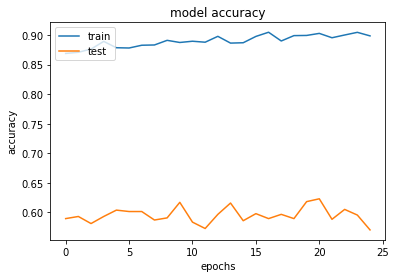

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting the graph for Loss vs Validation Loss

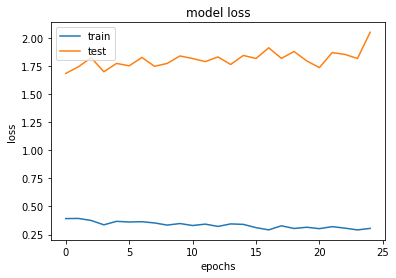

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# References

In [ ]:
# Dataset 

# Dog Images :  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip



# References 

# https://www.researchgate.net/publication/283813525_Dog_breed_classification_via_landmarks
# https://web.stanford.edu/class/cs231a/prev_projects_2016/output%20(1).pdf
# http://cs231n.stanford.edu/reports/2015/pdfs/automatic-dog-breed.pdf
# https://pdfs.semanticscholar.org/d58a/663d775c3ef6398d605b6d6dbd02fb3d8725.pdf
# https://github.com/nikbearbrown/NEU_COE
# Keras Documentation for Designing our own CNN : https://keras.io/
# Batch normalization in Neural Networks : https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c
# Image Augmenatation : https://towardsdatascience.com/image-augmentation-for-deep-learning-histogram-equalization-a71387f609b2
# Image Augmentation for Deep Learning With Keras : https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
# Deep learning and the rise of the GPU : https://www.ibm.com/developerworks/library/cc-machine-learning-deep-learning-architectures/index.html
# CNN : https://en.wikipedia.org/wiki/Convolutional_neural_network
# Deep learning architectures : https://www.ibm.com/developerworks/library/cc-machine-learning-deep-learning-architectures/index.html

# YouTube References

# https://www.youtube.com/watch?v=aircAruvnKk
# https://www.youtube.com/watch?v=IHZwWFHWa-w
# https://www.youtube.com/watch?v=Ilg3gGewQ5U
# MIT 6.S191: Introduction to Deep Learning https://youtu.be/JN6H4rQvwgY
# TensorFlow 101 (Really Awesome Intro Into TensorFlow) https://youtu.be/oxf3o8IbCk4
# Introduction to TensorFlow Tutorials https://youtu.be/er8RQZoX3yk


# Licenses

<a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/3.0/us/88x31.png" /></a><br>The text in the document by NISHANT GOHEL and KARAN BHAVSAR is licensed under <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/">Creative Commons Attribution 3.0 United States License</a>.<br><br>


The code in the document by NISHANT GOHEL and KARAN BHAVSAR is licensed under the MIT License https://opensource.org/licenses/MIT